## Deep Learning Project 1 

Comparing digits

### TODO Next : 

- Maybe get better performances ? 
- Add dropout layer and stuff like this
- Add Auxilary losses (also return CNNs results and use them with a loss function, similar to comparisson net)
- Benchmark
- Write report

In [1]:
import torch
import math
import dlc_practical_prologue as prologue
from torch import optim
from torch import Tensor
from torch import nn
from torch.nn import functional as F

In [2]:
# Generate the train and test sets.
N = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)

In [18]:
# Model Definition 

        
class Full_Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Layers that handle digit classification 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 200)
        self.fc2 = nn.Linear(200, 10)
        
        # Layers that handle comparisson 
        self.fc3 = nn.Linear(20, 200)
        self.fc4 = nn.Linear(200, 200)
        self.fc5 = nn.Linear(200, 2)
        
    def cnn(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x
    
    def mlp(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
    def forward(self, x):
        s = x.shape
        
        input_1 = x[:,0,:,:].reshape([s[0],1,s[2],s[3]])
        input_2 = x[:,1,:,:].reshape([s[0],1,s[2],s[3]])
        
        output_1 = self.cnn(input_1)
        output_2 = self.cnn(input_2)
        
        concatenated = torch.cat((output_1, output_2), 1)
        
        comparison = self.mlp(concatenated)
        return comparison   

torch.Size([1000, 2, 14, 14])


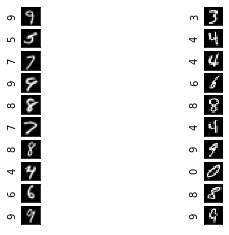

In [19]:
import matplotlib.pyplot as plt

print(train_input.shape)

fig ,axes = plt.subplots(10, 2)
for i in range(10):
    first = train_input[i][0,:,:]
    second = train_input[i][1,:,:]
    first_label = train_classes[i][0]
    second_label = train_classes[i][1]
    axes[i,0].imshow(first, cmap='gray')
    axes[i,0].set_ylabel(str(first_label.item()))
    axes[i,1].imshow(second, cmap='gray', interpolation='none')
    axes[i,1].set_ylabel(str(second_label.item()))
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])
    fig

In [20]:
def train_model_total(model, train_input, train_target, mini_batch_size, nb_epochs = 100, use_optimizer= None):
    criterion = nn.MSELoss()
    eta = 1e-3
    if use_optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=eta)
    if use_optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=eta)
    for e in range(nb_epochs):
        acc_loss = 0

        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            target = train_target.narrow(0, b, mini_batch_size).reshape(output.shape).float()
            
            loss = criterion(output, target)
            acc_loss = acc_loss + loss.item()
 
            model.zero_grad()
            loss.backward()
            
            if use_optimizer != None :
                optimizer.step()
            else :
                with torch.no_grad():
                    for p in model.parameters():
                        p -= eta * p.grad

        print(e, acc_loss)
        
def compute_nb_errors_total(model, input, target, mini_batch_size):
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.max(1)
        for k in range(mini_batch_size):
            if target[b + k, predicted_classes[k]] <= 0:
                nb_errors = nb_errors + 1

    return nb_errors

In [24]:
model_total = Full_Net()

train_target_one_hot = prologue.convert_to_one_hot_labels(train_input, train_target)
train_model_total(model_total, train_input, train_target_one_hot, mini_batch_size=250, nb_epochs=25, use_optimizer="adam")

0 5.103608816862106
1 1.1412552893161774
2 1.0051216781139374
3 0.8816184848546982
4 0.749685138463974
5 0.6347069144248962
6 0.5916983634233475
7 0.5579552203416824
8 0.5033061802387238
9 0.4848180413246155
10 0.44239556044340134
11 0.42169301956892014
12 0.3886314705014229
13 0.3638835996389389
14 0.3335956558585167
15 0.30689749121665955
16 0.27927839756011963
17 0.253370251506567
18 0.2276555858552456
19 0.20114244148135185
20 0.1765357181429863
21 0.15274933353066444
22 0.13064033910632133
23 0.10981520265340805
24 0.09140302613377571


In [25]:

test_target_total = prologue.convert_to_one_hot_labels(test_input, test_target)
nb_test_errors = compute_nb_errors_total(model_total, test_input, test_target_total, mini_batch_size=250)
print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                      nb_test_errors, test_input.size(0)))

test error Net 17.70% 177/1000


In [26]:
for i in range(10):
    input_to_test = test_input[i]
    first_label = test_classes[i][0]
    second_label = test_classes[i][1] 
    s = input_to_test.shape
    output = model_total(input_to_test.reshape([1,s[0], s[1], s[2]]))
    _, predicted_classes = output.max(1)
    print(f"Predicted : {first_label} {'>' if predicted_classes.item() == 0 else '<'} {second_label}")

Predicted : 0 < 7
Predicted : 4 > 1
Predicted : 8 < 7
Predicted : 2 < 9
Predicted : 5 < 4
Predicted : 0 < 0
Predicted : 7 < 6
Predicted : 1 < 9
Predicted : 6 < 8
Predicted : 1 < 7


In [35]:
# Benchmark of the basic network with Adam optimizer
nb_trials = 10
N = 1000
performances = []
for trial in range(nb_trials):
    
    # Generate Data 
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)
    train_target_one_hot = prologue.convert_to_one_hot_labels(train_input, train_target)
    test_target_total = prologue.convert_to_one_hot_labels(test_input, test_target)
    
    # Define the model 
    model_total = Full_Net()
    
    # Train the model
    train_model_total(model_total, train_input, train_target_one_hot, mini_batch_size=250, 
                      nb_epochs=25, use_optimizer="adam")
    
    # Evaluate performances 
    nb_test_errors = compute_nb_errors_total(model_total, test_input, test_target_total, mini_batch_size=250)
    print('test error Net {:d} {:0.2f}% {:d}/{:d}'.format(trial, (100 * nb_test_errors) / test_input.size(0),
                                                          nb_test_errors, test_input.size(0)))
    performances.append(nb_test_errors)
    
mean_perf = 100 * sum(performances) / (N * nb_trials)
print(f"Average precision of this architecture {mean_perf}")

0 5.172012269496918
1 2.676367402076721
2 1.355547457933426
3 1.0586470663547516
4 0.9494668543338776
5 0.8391359895467758
6 0.7461124807596207
7 0.6752743273973465
8 0.6142256408929825
9 0.5677820146083832
10 0.5235233679413795
11 0.492828793823719
12 0.46459154039621353
13 0.43744442611932755
14 0.4146461561322212
15 0.3924843296408653
16 0.3714643269777298
17 0.34783201664686203
18 0.3250824138522148
19 0.30218738317489624
20 0.2776138037443161
21 0.25381024181842804
22 0.23194891586899757
23 0.20976605266332626
24 0.18831634521484375
test error Net 0 15.90% 159/1000
0 15.587447047233582
1 3.369956284761429
2 1.5002793669700623
3 1.1437715590000153
4 0.9693275839090347
5 0.9438235014677048
6 0.8472919017076492
7 0.7855385690927505
8 0.7075682580471039
9 0.664476752281189
10 0.6309124827384949
11 0.6012694090604782
12 0.5788939595222473
13 0.5528712421655655
14 0.5316534265875816
15 0.5082411170005798
16 0.48228421062231064
17 0.4581543728709221
18 0.4339163601398468
19 0.40869272500